# Overview of Music Source Separation

*Wilcox, Coby*

## Abstract

Music source separation (MSS), is the practice of taking a given mix of music and decomposing it into one or more separate audio files that each 'separate' a target music source (bass, guitar, drums, vocals etc.) into their own audio data. Research in this particular field has been ongoing for decades and like many other fields has seen a massive leaps in progress from the relatively recent developments with neural networks[1-10]. My main goal was to look into data science and machine learning methods utilizing neural networks and also to understand how to work with audio data. The main ideas of my project will be split into several different folders:

*audio_processing* : An overview of how data is loaded and processed in a python environment. Begins with loading a .wav file and how the data itself appears, then looks at a numpy implementation of a short-time fourier transform pipeline, finally going over creating and interpretting a spectrogram. Also another report is included 'spectrogram_limits.ipynb' that goes over some of the issues of spectrogram-based models.

*residual_analysis* : This is a deep dive into the where and the why of the errors in the spectrogram based MSS model, detailed in 'spectrogram_limits.ipynb'.

*mss_basic_implementation* : A basic music source separation method involving median filtering. This was mainly to give myself an basic understanding of how a music source separation model would work before jumping into a neural network model.

*neural_network_basics* : Numpy implementation of neural networks which greatly aided my understanding and implementation of the neural network based MSS model.

*mss_nn_implementation* : My attempt at recreating the model detailed in this paper: *Conv-TasNet: Surpassing Ideal Time-Frequency Magnitude Masking for Speech Separation*[1]. In 'convtas_report.ipynb', an explanation of the architecture and main ideas of the model is given, while in 'model_report.ipynb' I go over how the model I created actually performed.



In [1]:
import display # module for displaying results of analysis

## 1. Introduction

Isolated recordings of music tracks can be surprisingly hard to obtain, while often kept by the recording artist themself, as a independent musician or producer, it's common for the only option availible is to record the part themself to obtain a decent quality recording. However, the equipment and skill required to do this may not be availible to your average consumer. Thus application of a statistical machine learning model to obtain estimations of these recordings may be the next best thing. The uses of a source separated piece of music, aside from being able to be used by musicians for education purposes, a source separated song can be used in music production for sampling, and has been shown to aid in processes for automatic music transcription [2-3] , lyric recognition [5], singer/instrument identification [4,6], and fundamental frequency estimation [7] to name a few. 

Recently there have been a number of new MSS models that achieve state-of-the-art results using very different techniques such as Demucs and Band-Split RNN [9-10]. In this study however I chose to recreate a relatively more simple MSS model called Conv-TasNet. Conv-TasNet published in 2017 and was actually made for the purpose of speech separation, however people found when applied to the task of MSS would achieve very impressive results. As a result several well known MSS's such as Demucs and Spleeter [8] have been built using Conv-TasNet as a foundation. That is not to decry the quality and complexity of Conv-TasNet however, as it achieves results that are still impressive to this day.

To help with my understanding of MSS and ConvTas-Net, I employed several more rudementary MSS models and numpy implementations of neural networks, documenting my thought processes and findings.

## 2. Data

The data I used in this study was MUSDB-18, which is a dataset containing 150 songs with their mix audio tracks, isolated drums, bass, vocals and other sources audio tracks or 'stems', and meta-information on the songs like name and artist. The songs of the dataset are all copyright-free, mostly being taken from the *Mixing Secrets- Free Multitrack Download Library* (https://www.cambridge-mt.com/ms/mtk/), though other songs have been taken from other free music libraries or donated by artists. The dataset is divided into a training set of 100 songs and a test set of 50 songs. To parse the dataset, I used the musdb python package which can simply be installed with `! pip install musdb`. It should be noted however, that to use musdb one must also install ffmpeg and stempeg, which are libraries used to work with video and audio on python. These cannot just be installed using pip, they have to be installed on their website: https://ffmpeg.org/.

Generally each song is within the time range of 1:30 to 2:30 in duration and overall the dataset contained ~10 hours of music. When using the songs to train or test the neural network, I would generally split a song into batches where each observation is 400 samples long with batches of about 50. 

## 3. Methodology

### 3.1 Spectral Analysis

One of the most fundamental tools of spectral analysis is the short-time Fourier Transform, which is a wonderful mathematical function that allows us to decompose a summation of signals into its individual signals. Generally the Fourier Transform is applied to windowed overlapping chunks of a time series data, of some length that is power 2 for computational reasons. The Fourier Transform in all its glory can be represented like this:

$$d(\omega_j) = \frac{1}{\sqrt{n}}\sum_{t=1}^{n}{x_t \cdot e^{-2\pi i\omega_j t}}$$

Where $x_t$ are the windowed overlapping frames of the audio signal, and $\omega_j$ are the frequencies.

We can then directly use this calculation to create our periodograms which are a measure of the contribution of a frequency within a signal

$$|d(\omega_j)|^2=I(\omega_j) = \sum_{h=-(n-1)}^{n-1}{\hat{\gamma}(h) \cdot e^{-2\pi i\omega_j h}}$$

Where $\hat{\gamma}(h)$ is the sample autocorrelation, and $\omega_j$ are the frequencies.

Lastly, many of my visualizations are spectrograms which aren't a concept we talked about in class however, they are a very close relative to these two concepts. Essentially when you place each of these overlapping chunk's periodograms chronologically with frequencies as the y-axis and color them based on the level of spectral density, you get a spectrogram which is one of the most intuitive ways you can visualize a piece of music. 

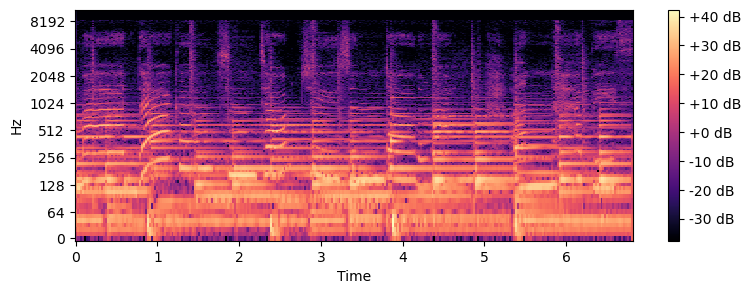

In [2]:
display.spectrogram() # example spectrogram

### 3.3 Neural Network

Neural networks are an idea that are hard to express verbally, but in essence they are a non-linear model that is based on passing data through nodes or neurons that each have some mathematical function attached (typically just being multiplied by some weight) to the neuron. The data will often pass through multiple layers of these neurons until being it outputs some estimate of its target. To which, using a process called backpropogation, the parameters of the model are adjusted to output something closer to the target. The most basic type of layer in a neural network is called a dense layer. The dense layer connects every single neuron in the base layer to a weight to form a weighted sum calculation for a neuron's activation in this next dense layer. 

For the mathematical notation note that:
- $i$ denotes amount of neurons in the previous layer
- $j$ denotes amount of neurons to be made in this dense layer.
- $w_{ij}$ denotes the weight for the ith input into the jth output neuron.
- $b_j$ denotes the bias for the jth output neuron.
- ${x_i}$ denotes the set of input values from the previous layer
- ${y_j}$ denotes the set of output values from this dense layer.

You can write a given output as: $y_j = x_1w_{1j} + ... + x_1w_{ij} + b_j$

However using matrix multiplication you can rewrite this as:
- $W_j$ denotes the $j$ x $i$ matrix that stores all the weight values for a output neuron.
- $b$ denotes a vector of bias terms.

$$Y = W_jX + b$$

### 3.4 Convolutions in a Neural Network:

Of course, in the Conv-TasNet model, we are mostly dealing with convolutional neural network layers. Conceptually a convolutional neural network layer is when instead of every single previous neuron is put into a weighted sum to make a new neuron, a new neuron is weighted sum of a portion of the previous neurons. You can represent a convolutional layer with inputs, denoted $X$, being 3-dimensional objects that are almost like several pages of a book. Each page,$X_n$, is a matrix (probably a square matrix) and the amount of pages can be thought of as the depth, denoted $n$. The elements of the inputs represent activations for a given input. Each element denoted by: $$x_{i,j}^n \in X_n$$

The kernels object, denoted $K$, will be 4-dimensional, with a given kernel,$K_{dn}$, having $n$ 2d matrices to apply to each the matrix at each depth in the input, and then there can be multiple kernels in a kernel which each are denoted by $d$. The elements of kernels represent weights that are attached to the inputs to calculate a weighted sum. Weights denoted by: $$w_{i,j}^d \in K_{dn}$$

Then for each kernel the layer contains, a separate bias matrix, denoted $B_d$ will be added to the resulting weighted sums for each output. Elements denoted: $$b_{i,j}^d \in B_d$$

Finally to show how the full output matrix of the convolution layer, $Y_d$ is mathematically represented: 
$$Y_d = B_d + X_1 \star K_{1d} + ... + X_n \star K_{nd}$$

$$Y = B + X \cdot|\star K $$

### 3.5 ConvTas-Net:

A model created by Yi Luo and Nima Mesgarani, discussed in their paper [1]. The model was initially developed for speech separation, however when applied to MSS tasks it achieved impressive results. The model is based on a U-Net architecture and operates on just the waveform of a given piece of music. I go into more detail about each part individually and explain how it works in `convtas_report.ipynb`

## 4. Results

The process of creating my model was an intense crash course in the makings of neural networks and TensorFlow. As the model I was trying to recreate was coded in PyTorth it forced me to learn the basics of both frameworks and overall taught me a lot about neural networks. The outputs of the model in the end with pretty minimal training ended up being passable. 

The outputs, seem to have a large amount of interference coming in from other sources so the model appears to be not cutting out enough overall. I think to improve this I could try to make my data be trained in the model in a more optimized format or I could try to introduce things to take out more from the model output, possibly things like dropout to the model could feasibly improve performance. While the results themselves could be improved I am very proud of my progress and understanding of these complex concepts.

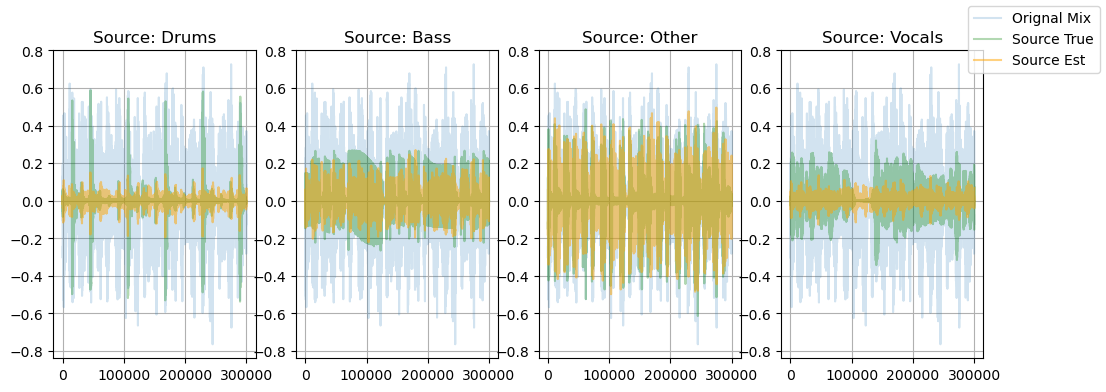

In [2]:
display.display_nn_est()

Looking over the generated sources in comparison to their targets, it is clear the model is attempting to generate the correct signals. Especially looking at the bass estimation it appears quite close to the target, but then looking at something like the drums estimation its clear there is a lot of work that need to be done for the model still. Of course, please check out the model_report for more information if you are interested.

## Conclusion

In the end I am overjoyed with how my project went, I think there are a number of things I wish I could improve on and make better, but I my objective with this project was always to learn more about audio processing, music source separation, and neural networks and in all three of those respects I improved greatly! In the future I would like to do more research into building more advanced machine learning models that process audio data, however I would be very interested in one with a whole objective like automatic music transcription or creating a music recommendation system. Improvement wise I would like to make my ConvTas-Net model work a bit better, as I was a little disappointed with how they performed overall, though I am happy that they are functioning. I am looking forward to doing more research, and cannot wait to learn more and test my skills!

I also want to take this oppurtunity to thank Professor Ichiba for his guidance throughout the project, I learned a lot from this project and his help was instrumental in my learning. I am grateful to someone as knowledgable as yourself to help me nuture my passion for statistics. Thank you.

## Cited Works

[1] Luo, Yi, and Nima Mesgarani. "Conv-TasNet: Surpassing Ideal Time-Frequency Magnitude Masking for Speech Separation." Proceedings of the 2019 IEEE International Conference on Acoustics, Speech, and Signal Processing (ICASSP), 2019, pp. 775-779.

[2] Mark D Plumbley, Samer A Abdallah, Juan Pablo Bello, Mike E Davies, Giuliano Monti, and Mark B Sandler. Automatic music transcription and audio source separation. Cybernetics &Systems, 33(6):603–627, 2002

[3] Ethan Manilow, Prem Seetharaman, and Bryan Pardo. Simultaneous separation and transcription of mixtures with multiple polyphonic and percussive instruments. In ICASSP 2020-2020 IEEE International Conference on Acoustics, Speech and Signal Processing (ICASSP), 771–775. IEEE, 2020.

[4] Toni Heittola, Anssi Klapuri, and Tuomas Virtanen. Musical instrument recognition in polyphonic audio using source-filter model for sound separation. In ISMIR, 327–332. 2009.

[5] Annamaria Mesaros and Tuomas Virtanen. Automatic recognition of lyrics in singing. EURASIP Journal on Audio, Speech, and Music Processing, 2010(1):546047, 2010

[6] Felix Weninger, Martin Wöllmer, and Björn Schuller. Automatic assessment of singer traits in popular music: gender, age, height and race. In Proc. 12th Intern. Society for Music Information Retrieval Conference, ISMIR 2011, Miami, FL, USA. 2011.

[7] Andreas Jansson, Rachel M Bittner, Sebastian Ewert, and Tillman Weyde. Joint singing voice separation and f0 estimation with deep u-net architectures. In 2019 27th European Signal Processing Conference (EUSIPCO), 1–5. IEEE, 2019

[8] Hennequin, Romain, Anis Khlif, Felix Voituret, and Manuel Moussallam. "Spleeter: A Fast and State-of-the-Art Music Source Separation Tool with Pre-trained Models." ISMIR 2019 Late-Breaking/Demo, 2019.

[9] Rouard, Simon, Francisco Massa, and Alexandre Défossez. "Hybrid Transformers for Music Source Separation." arXiv, 15 Nov. 2022.

[10] Luo, Yi, and Jianwei Yu. "Music Source Separation with Band-split RNN." arXiv, 2021.

[11] Emmanuel Vincent, Rémi Gribonval, and Cédric Févotte. Performance measurement in blind audio source separation. IEEE transactions on audio, speech, and language processing, 14(4):1462–1469, 2006.

[12] Jonathan Le Roux, Scott Wisdom, Hakan Erdogan, and John R Hershey. Sdr–half-baked or well done? In ICASSP 2019-2019 IEEE International Conference on Acoustics, Speech and Signal Processing (ICASSP), 626–630. IEEE, 2019.